**Prepare Data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

In [2]:
# copy data into local data driectory
# !wget -O ./data/car_data.csv https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

In [3]:
# load data into pandas dataframe
df = pd.read_csv ('data/car_data.csv')
df.shape

(11914, 16)

In [4]:
# list original columns
df.columns

Index(['Make', 'Model', 'Year', 'Engine Fuel Type', 'Engine HP',
       'Engine Cylinders', 'Transmission Type', 'Driven_Wheels',
       'Number of Doors', 'Market Category', 'Vehicle Size', 'Vehicle Style',
       'highway MPG', 'city mpg', 'Popularity', 'MSRP'],
      dtype='object')

In [5]:
# select only key columns
cols=['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders', 
      'Transmission Type', 'Vehicle Style','highway MPG', 'city mpg', 'MSRP']

df = df[cols]
df.shape

(11914, 10)

In [6]:
# format column names
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.columns

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg',
       'msrp'],
      dtype='object')

In [7]:
# rename msrp to price
df.rename(columns={"msrp": "price"}, inplace=True)
df.columns

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg',
       'price'],
      dtype='object')

In [8]:
df.shape

(11914, 10)

In [9]:
# fill missing values with 0
print('values before:\n', df.isnull().sum()) 
df = df.fillna(0)

values before:
 make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
price                 0
dtype: int64


In [10]:
# make a copy of data in case required to be restored later
df_copy = df.copy()
df_copy.shape

(11914, 10)

**1: ROC AUC feature importance**

In [13]:
features = ["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg"]
y = df.price.values

for f in features:
    # Get the indices that would sort feature f
    sorted_indices = np.argsort(df[f])

    # Sort both x and y based on the sorted indices
    x_sorted = df[f][sorted_indices]
    y_sorted = y[sorted_indices]

    # Now, you can calculate AUC using x_sorted and y_sorted for feature f
    print(f, auc(x_sorted, y_sorted))

engine_hp 382758612.0
engine_cylinders 4858036.0
highway_mpg 15603476.0
city_mpg 8155442.5


**2. Training the model - AUC of this model on the validation dataset**

*Make price binary*

In [11]:
mean = df.price.mean()
mean

40594.737032063116

In [12]:
df['price'] = (df['price'] > mean).astype(int)

In [13]:
df.rename(columns={"price": "above_average"}, inplace=True)

In [14]:
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,0


*Split the data*

In [15]:
# setup train/validation/test split with Scikit-Learn
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [16]:
len(df_train), len(df_val), len(df_test)

(7148, 2383, 2383)

In [17]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [18]:
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

In [19]:
# identify categorical and numerical columns
cat = list(df.dtypes[df.dtypes == 'object'].index)
num = list(df.dtypes[(df.dtypes == 'int64') | (df.dtypes == 'float64')].index)
num.remove('above_average')

In [20]:
cat

['make', 'model', 'transmission_type', 'vehicle_style']

In [21]:
num

['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [58]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[cat + num].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[cat + num].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [60]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
# solver='lbfgs' is the default solver in newer version of sklearn
# for older versions, you need to specify it explicitly
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [66]:
y_pred = model.predict_proba(X_val)[:, 1]

In [70]:
churn_decision = (y_pred >= 0.5)

In [72]:
(y_val == churn_decision).mean().round(3)

0.936

*AUC of validation*

In [73]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
# solver='lbfgs' is the default solver in newer version of sklearn
# for older versions, you need to specify it explicitly
model.fit(X_val, y_val)

LogisticRegression(max_iter=1000, solver='liblinear')

In [77]:
y_pred = model.predict_proba(X_val)[:, 1]

In [78]:
churn_decision = (y_pred >= 0.5)

In [79]:
(y_val == churn_decision).mean().round(3)

0.955

In [82]:
roc_auc_score(y_val, y_pred).round(3)

0.988

**3: Precision and Recall**

In [86]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [87]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [88]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [89]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[1681,   41],
       [  67,  594]])

In [90]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.71, 0.02],
       [0.03, 0.25]])

In [91]:
p = tp / (tp + fp)
p

0.9354330708661417

In [92]:
r = tp / (tp + fn)
r

0.8986384266263238

In [93]:
tpr = tp / (tp + fn)
tpr

0.8986384266263238

In [94]:
fpr = fp / (fp + tn)
fpr

0.023809523809523808

In [96]:
thresholds = np.linspace(0, 1, 101)
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

*Plot TPR and FPR*

In [97]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [98]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

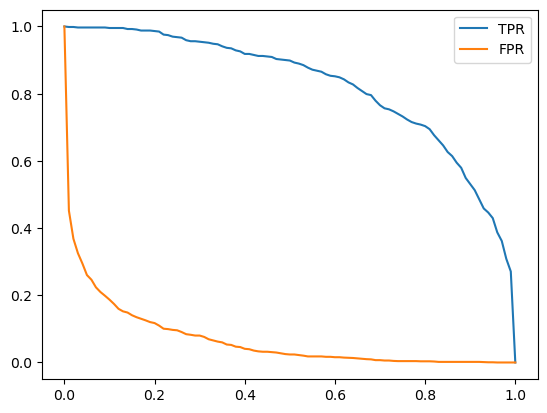

In [100]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

*Plot Precision and Recall*

In [103]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [104]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

# p = tp / (tp + fp)
# r = tp / (tp + fn)
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

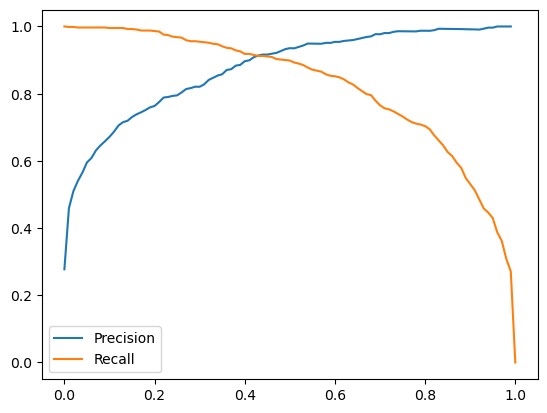

In [105]:
plt.plot(df_scores.threshold, df_scores['p'], label='Precision')
plt.plot(df_scores.threshold, df_scores['r'], label='Recall')
plt.legend()

**4. F1 score**

In [111]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [112]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [113]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [114]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[1681,   41],
       [  67,  594]])

In [115]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.71, 0.02],
       [0.03, 0.25]])

In [117]:
p = tp / (tp + fp)
p

0.9354330708661417

In [118]:
r = tp / (tp + fn)

In [119]:
r

0.8986384266263238

In [ ]:
# F-Measure = (2 * Precision * Recall) / (Precision + Recall)

In [124]:
F1_score = (2 * df_scores['p'] * df_scores['r']) / (df_scores['p'] + df_scores['r'])
F1_score

0      0.434297
1      0.628871
2      0.675192
3      0.701064
4      0.721401
         ...   
96     0.558342
97     0.531111
98     0.471676
99     0.426190
100         NaN
Length: 101, dtype: float64

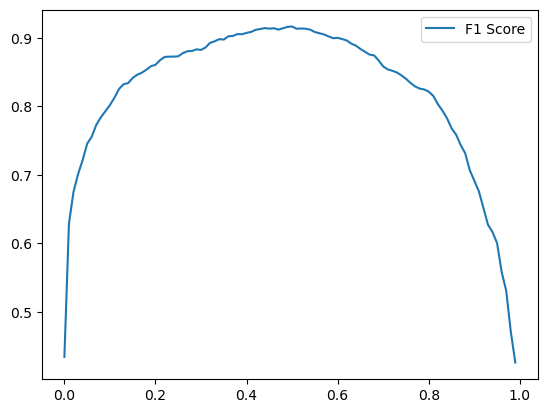

In [125]:
plt.plot(df_scores.threshold, F1_score, label='F1 Score')
plt.plot(df_scores.threshold, F1_score, label='F1 Score')
plt.legend()

In [133]:
F1_score[52]


0.9137529137529138

In [135]:
F1_score[32]

0.8928317955997161

**5: 5-Fold CV**

In [23]:
!pip install tqdm
from tqdm.auto import tqdm

In [26]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[cat + num].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [27]:
dv, model = train(df_train, y_train, C=1.0)

In [31]:
def predict(df, dv, model):
    dicts = df[cat + num].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [32]:
y_pred = predict(df_val, dv, model)

In [43]:
df_full_train

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
3181,Cadillac,CT6,2016,265.0,4.0,AUTOMATIC,Sedan,31,22,1
5357,Mercedes-Benz,GLS-Class,2017,449.0,8.0,AUTOMATIC,4dr SUV,18,14,1
4874,Kia,Forte,2016,173.0,4.0,AUTOMATIC,Coupe,34,25,0
8102,Dodge,RAM 250,1993,180.0,6.0,MANUAL,Regular Cab Pickup,16,11,0
10400,Hyundai,Tiburon,2008,172.0,6.0,AUTOMATIC,2dr Hatchback,24,17,0
...,...,...,...,...,...,...,...,...,...,...
11284,Toyota,Venza,2014,181.0,4.0,AUTOMATIC,Wagon,26,20,0
5191,Pontiac,G6,2009,219.0,6.0,AUTOMATIC,Sedan,26,17,0
5390,Volkswagen,Golf GTI,2016,220.0,4.0,AUTOMATED_MANUAL,2dr Hatchback,33,25,0
860,Saab,9-5,2009,260.0,4.0,AUTOMATIC,Wagon,27,17,1


In [44]:
print(df_full_train.shape)
print(df_train.shape)
print(df_val.shape)
print(y_train.shape)

(9531, 10)
(7624, 10)
(1907, 10)
(7148,)


In [48]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.977 +- 0.005


**6: Hyperparemeter Tuning**

In [54]:
n_splits = 5

for C in tqdm([0.01, 0.1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.9f +- %.5f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.976699515 +- 0.00481
C=0.1 0.976699515 +- 0.00481
C=5 0.976699515 +- 0.00481
C=10 0.976699515 +- 0.00481
